<a href="https://colab.research.google.com/github/hursoo/big_k-modern_1/blob/main/gb_061_writer_difference_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.개요
- 생성한 dmr 모델 불러와서 문서별 토픽 분포 산출
- dtm: doc는 여기서는 5개 문장 통합한 것(doc). term은 여기서는 토픽. 값은 문서별 토픽 분포
- 2기(10q~24q, 1922.10-1926.8) 문서의 토픽 분포만 남김
- 2기 문서만으로 산점도 분포 확인

In [ ]:
# 구글 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 경로 지정

file_path = '/content/drive/MyDrive/_big1_25-1_code/'

In [ ]:
## 런타임 다시 시작 후엔 이 셀 건너뛸 것 !

# =================================================================
# 1단계: 나눔 폰트 설치 (이 셀을 실행한 후, 런타임을 다시 시작해야 합니다)
# =================================================================
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
!pip install tomotopy

In [ ]:
import sys
import os, re
import pandas as pd
import numpy as np
import random
import warnings

from tomotopy import DMRModel
from tomotopy import TermWeight
from tomotopy import utils
import tomotopy as tp

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕으로 설정 (Colab 기본 포함) ###
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호가 정상 표시되도록 설정

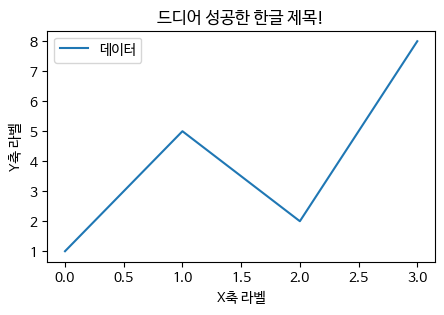

In [ ]:
# --- 이제 그래프를 그려도 경고가 뜨지 않습니다. ---

# 예시 그래프
# (여기에 원래 그리려던 그래프 코드를 넣으시면 됩니다)
plt.figure(figsize=(5, 3))
plt.title('드디어 성공한 한글 제목!')
plt.xlabel('X축 라벨')
plt.ylabel('Y축 라벨')
plt.plot([1, 5, 2, 8], label='데이터')
plt.legend()
plt.show()

# 2.문서를 시기별로 구분

In [ ]:
# 통합 데이터 불러오기
df = pd.read_excel(file_path + 'result/gb_data_2(doc,1g2g,wn_cls,20250414).xlsx') ###
print(df.shape)
df[:3]

(6802, 9)


,doc_id,doc_raw,doc_split_12gram,r_no,title,w_new,ho_no,grid_1,wn_cls
0,1,創刊辭 强者도 부르짖고 弱者도 부르짖으며 優者도 부르짖고 劣者도 부르짖도다 東西南北...,창간 辭 강자 약자 優者 劣者 동서 남북 사해 팔방 소리 소리 판단 좌우 間 다수 ...,1,創刊辭,uk01,1,01q,0
1,2,哲人은 말하되 多數 人民의 聲은 곳 神의 聲이라 하엿나니 神은 스스로 要求가 없는지...,哲人 다수 인민 요구 인민 소리 요구 발표 갈앙 인민 소리 갈앙 다수 인민 갈앙 요...,1,創刊辭,uk01,1,01q,0
2,3,世界를 알라 사람은 天使도 안이며 野獸도 안이오 오즉 사람일 뿐이로다 이만치 進化된...,세계 사람 야수 사람 진화 진화 지식 진화 도덕 동물 세계 천당 지옥 세계 진화 국...,2,世界를 알라,uk01,1,01q,0


In [ ]:
# 1기와 2기의 경계 확인
df.query('grid_1 == "09q"')[-3:]

,doc_id,doc_raw,doc_split_12gram,r_no,title,w_new,ho_no,grid_1,wn_cls
2744,2745,卽 男子二十歲 女子十六歲에 達하면 國民된 義務로서 無償으로써 國家의 勞務에 服할 것...,남자 여자 국민 의무 국가 노무 규정 남자 여자 매년 남자 일정 物 건축 생활 여자...,133,勃牙利의 國民皆勞主義에 對한 一考,uk05,27,09q,0
2745,2746,또 男子 十七歲 女子 十二歲에 達하면 志願兵으로 勞務에 服함을 得하게 하엿는데 勞務...,남자 여자 노무 노무 주요 도로 철도 건설 건축 공공 사업 過去 收得 수확 막대 발...,133,勃牙利의 國民皆勞主義에 對한 一考,uk05,27,09q,0
2746,2747,만일 現在의 徵兵制度가 貧富貴賤의 別이 업시 國民이 平等的으로 兵役에 服하는 點에서...,현재 빈부 귀천 국민 평등 국방 化 민중 국가 국방 費 절약 합리 국민 국민 皆兵 ...,133,勃牙利의 國民皆勞主義에 對한 一考,uk05,27,09q,0


In [ ]:
# 1기와 2기의 경계 확인
df.query('grid_1 == "10q"')[:3]

,doc_id,doc_raw,doc_split_12gram,r_no,title,w_new,ho_no,grid_1,wn_cls
2747,2748,貴重한 經驗과 高潔한 犧牲/◇開闢의 新使命과 開闢의 新活動◇ 어느듯 二個年半이 되엇...,귀중 경험 고결 희생 사명 新 新 활동 無理 잡지 시작 동기 현명 제위 讀者 양해 ...,134,貴重한 經驗과 高潔한 犧牲/開闢의 新使命과 開闢의 新活動,uk05,28,10q,0
2748,2749,世上에 이미 開闢의 運이 돌앗스며 朝鮮形便이 더욱 開闢이 되어야 하겟고 우리들의 ...,세상 개벽 朝鮮 형편 개벽 책임 부합 시작 세월 세월 시간 환경 처지 형편 수업 마...,134,貴重한 經驗과 高潔한 犧牲/開闢의 新使命과 開闢의 新活動,uk05,28,10q,0
2749,2750,슯흐다 이피자 風雨가 오고 조흔일에 魔가 만흔지라 우리들의 이 計劃과 理想은 百가...,풍우 계획 理想 분투 오늘 날 완전 당초 理性 도안 실시 讀者 유감 유감 時事 정치...,134,貴重한 經驗과 高潔한 犧牲/開闢의 新使命과 開闢의 新活動,uk05,28,10q,0


In [ ]:
# 전기,후기: doc_id는 2748부터 끝까지
df['period'] = np.where(
    df['doc_id'] < 2748,  # 조건
    'p1',                          # 조건이 참일 때
    'p2'                           # 조건이 거짓일 때
)
df

,doc_id,doc_raw,doc_split_12gram,r_no,title,w_new,ho_no,grid_1,wn_cls,period
0,1,創刊辭 强者도 부르짖고 弱者도 부르짖으며 優者도 부르짖고 劣者도 부르짖도다 東西南北...,창간 辭 강자 약자 優者 劣者 동서 남북 사해 팔방 소리 소리 판단 좌우 間 다수 ...,1,創刊辭,uk01,1,01q,0,p1
1,2,哲人은 말하되 多數 人民의 聲은 곳 神의 聲이라 하엿나니 神은 스스로 要求가 없는지...,哲人 다수 인민 요구 인민 소리 요구 발표 갈앙 인민 소리 갈앙 다수 인민 갈앙 요...,1,創刊辭,uk01,1,01q,0,p1
2,3,世界를 알라 사람은 天使도 안이며 野獸도 안이오 오즉 사람일 뿐이로다 이만치 進化된...,세계 사람 야수 사람 진화 진화 지식 진화 도덕 동물 세계 천당 지옥 세계 진화 국...,2,世界를 알라,uk01,1,01q,0,p1
3,4,사람과 世界는 決코 논하볼 것이 안이엇다 사람으로 된 世界 世界로 된 사람 둘이 안...,사람 세계 사람 세계 세계 사람 세계 대표 시대 가치 사람 대표 문화 상징 符號 사...,2,世界를 알라,uk01,1,01q,0,p1
4,5,過去는 論할 것이 업도다만은 今日과 가티 交通이 이마마하고 知識이 이마마하고 一切의...,過去 금일 교통 지식 일체 문물 오늘 세계 理解 공자 천하 천하 理解 오늘 날 사람...,2,世界를 알라,uk01,1,01q,0,p1
...,...,...,...,...,...,...,...,...,...,...
6797,6798,미국에서는 每人에게 奴僕이 식 돌아감니다 단 機械奴僕만 이건 무슨 말이냐 하면 기계...,미국 노복 機械 노복 機械 力 운전 계산 人力 계산 미국 국민 사람 機械 輸入 숫자...,334,유로빠와 아메리카(一) 금년 봄에 모쓰크바 엑쓰페리멘탈 劇場에서 한 「트로츠끼」의 講演.,김철산,72,24q,2,p2
6798,6799,매년 저축은ㅡ필요의 비용을 다 쓴 뒤의 것 말이지요ㅡ매년에 억 딸라 金 루불로는 억...,저축 필요 비용 미국 교과 書 실상 미국 富豪 캐나다 영국 미국 부분 미국 캐나다 ...,334,유로빠와 아메리카(一) 금년 봄에 모쓰크바 엑쓰페리멘탈 劇場에서 한 「트로츠끼」의 講演.,김철산,72,24q,2,p2
6799,6800,그러고 또 캐나다는 아조 겸손스럽게 좀 유순하게 미국의 北邊繼續이라고ㅡ국제연맹의 축...,캐나다 미국 국제_연맹 국제_연맹 원인 경제 機械 캐나다 산업 북미 자본 점령 부분...,334,유로빠와 아메리카(一) 금년 봄에 모쓰크바 엑쓰페리멘탈 劇場에서 한 「트로츠끼」의 講演.,김철산,72,24q,2,p2
6800,6801,25년 전에는 영국이 美보다 배나 더 되게 輸入하엿섯음니다 캐나다 사람들은 지금 그...,영국 미국 輸入 캐나다 사람 영국 一部 미국 호주 캐나다 진화 호주 일본 침입 보호...,334,유로빠와 아메리카(一) 금년 봄에 모쓰크바 엑쓰페리멘탈 劇場에서 한 「트로츠끼」의 講演.,김철산,72,24q,2,p2


In [ ]:
# 시기구분 정보 확인 코드
df.groupby(['period', 'grid_1'])['doc_id'].count()

period  grid_1
p1      01q       193
        02q       223
        03q       296
        04q       292
        05q       435
        06q       333
        07q       410
        08q       413
        09q       152
p2      10q       298
        11q       315
        12q       261
        13q       198
        14q       393
        15q       456
        16q       254
        17q       154
        18q       201
        19q       223
        20q       224
        21q       226
        22q       248
        23q       324
        24q       280
Name: doc_id, dtype: int64

# 3.2기의 주요 필자 현황

## 3.1.필자 그룹 확인
- 통합 데이터의 'wn_cls' 정보 확인
- 0: 필자 미상
- 1: 개벽 주도층 - 김기전, 박달성, 이돈화, 차상찬
- 2: 사회주의 필자 <- 기존 연구에 의함
- 3: 기타 - 0~2 이외

In [ ]:
# df 현황
print(df.shape)
df.head(3)

(6802, 10)


,doc_id,doc_raw,doc_split_12gram,r_no,title,w_new,ho_no,grid_1,wn_cls,period
0,1,創刊辭 强者도 부르짖고 弱者도 부르짖으며 優者도 부르짖고 劣者도 부르짖도다 東西南北...,창간 辭 강자 약자 優者 劣者 동서 남북 사해 팔방 소리 소리 판단 좌우 間 다수 ...,1,創刊辭,uk01,1,01q,0,p1
1,2,哲人은 말하되 多數 人民의 聲은 곳 神의 聲이라 하엿나니 神은 스스로 要求가 없는지...,哲人 다수 인민 요구 인민 소리 요구 발표 갈앙 인민 소리 갈앙 다수 인민 갈앙 요...,1,創刊辭,uk01,1,01q,0,p1
2,3,世界를 알라 사람은 天使도 안이며 野獸도 안이오 오즉 사람일 뿐이로다 이만치 進化된...,세계 사람 야수 사람 진화 진화 지식 진화 도덕 동물 세계 천당 지옥 세계 진화 국...,2,世界를 알라,uk01,1,01q,0,p1


In [ ]:
# 필자 그룹별 논설 수 정보 확인

## 필요한 컬럼 선택
rons = df[['r_no', 'title', 'w_new', 'ho_no', 'grid_1','wn_cls', 'period']]
# r_no 기준으로 중복 제거 (논설 고유 기준)
ron_original = rons.drop_duplicates(subset='r_no')

# 필자 그룹(w_cls)별 논설 수 집계
#writer_group_count = ron_original.groupby('wn_cls')['r_no'].count()

# 1,2기별 구분
writer_group_count_period = ron_original.pivot_table(
    index='wn_cls',
    columns='period',
    values='r_no',
    aggfunc='count'
)
writer_group_count_period

period,p1,p2
wn_cls,,
0,30,55
1,56,35
2,2,44
3,45,67


In [ ]:
# 논설/필자 현황
print(ron_original.shape)
ron_original.head(3)

(334, 7)


,r_no,title,w_new,ho_no,grid_1,wn_cls,period
0,1,創刊辭,uk01,1,01q,0,p1
2,2,世界를 알라,uk01,1,01q,0,p1
22,3,時急히 解決할 朝鮮의 二大問題,박달성,1,01q,1,p1


## 3.2.2기 구간별/그룹별 필자 및 논설 수

In [ ]:
# 2기 논설별 필자 1,2그룹 정보
ron_12gp = ron_original.query('period == "p2" and (wn_cls == 1 or wn_cls == 2)')
ron_12gp_idx = ron_12gp.set_index('r_no')
print(ron_12gp_idx.shape)
ron_12gp_idx

(79, 6)


,title,w_new,ho_no,grid_1,wn_cls,period
r_no,,,,,,
140,"朝鮮人과 政治的 生活, -民衆政治의 今日-總督政治 10년 후-, -朝鮮人의 政治生活...",이돈화,29,10q,1,p2
144,有耶無耶? 朝鮮人의 「生道」(生道를 찾기 위하야 雙眼을 四方에 구을리다가),박달성,29,10q,1,p2
145,南北朝鮮을 巡迴한 者의 酬酌,김기전,29,10q,1,p2
157,"第一의 解放과 第二의 解放, 人類歷史上의 二大解放宣言",김기전,32,11q,1,p2
160,"農民運動國産運動이 勃發하기까지, (餓鬼의 威壓에서 解放되려하는 民衆運動의 二三)",김기전,32,11q,1,p2
...,...,...,...,...,...,...
325,"朝鮮思想運動者들의 階級的組成을 推究하면서, 朝鮮의 熟慮",박진순,71,24q,2,p2
327,近世植民政策의 終幕(近世植民政策의 起源과 由來其三),박형병,71,24q,2,p2
329,士禍와 黨爭,차상찬,71,24q,1,p2


In [ ]:
import pandas as pd

# 필요한 컬럼만 추출
df_subset = ron_12gp_idx[['grid_1', 'w_new', 'wn_cls']]

# 논설 수 세기
author_counts = df_subset.groupby(['grid_1', 'wn_cls', 'w_new']).size().reset_index(name='count')

# 필자명(개수) 형태로 문자열 결합
author_counts['entry'] = author_counts['w_new'] + '(' + author_counts['count'].astype(str) + ')'

# 각 grid_1별 wn_cls 그룹을 하나의 문자열로 묶기
pivot_table = author_counts.groupby(['grid_1', 'wn_cls'])['entry'].apply(', '.join).reset_index()

# 가독성을 위해 wn_cls 값 → 텍스트로 변환
wn_cls_map = {1: '개벽 주도층', 2: '사회주의자'}
pivot_table['wn_cls'] = pivot_table['wn_cls'].map(wn_cls_map)

# 최종 형태로 피벗
final_table = pivot_table.pivot(index='grid_1', columns='wn_cls', values='entry').fillna('')

# 정렬
final_table = final_table.sort_index()

# 출력
final_table

wn_cls,개벽 주도층,사회주의자
grid_1,,
10q,"김기전(1), 박달성(1), 이돈화(1)",
11q,김기전(2),
12q,김기전(1),
13q,,"양명(1), 이성태(2), 주종건(1)"
14q,박달성(1),"김기진(1), 정지현(1), 주종건(1)"
15q,"김기전(2), 이돈화(1)","O民(1), 김기진(1), 양명(1), 이성태(1), 정지현(2)"
16q,"김기전(1), 이돈화(1)",
17q,"박달성(1), 이돈화(2), 차상찬(1)","박헌영(1), 이성태(1)"
18q,이돈화(1),"김경재(1), 이성태(1), 정지현(1)"


# 4.2기 주요 필자 그룹별 토픽 분포
- 연구질문의 초점: 2기 주요 필자 그룹별 사회주의 토픽
- 2기 주요 필자별 문서 데이터 호출 -> 저장한 모델로 문서별 토픽 분포 산출 -> 2기 필자 그룹별 문서 부분만 남김

## 4.1.(A) 2기 주요 필자별 문서 호출

In [ ]:
# ron_gp_idx(2기 논설별 필자 1,2그룹) 를 문서별 정보로 출력
ron_12gp_idx.index # 논설 인덱스 정보
doc_12gp_idx = df[df['r_no'].isin(ron_12gp_idx.index)].set_index('doc_id')
doc_12gp_idx

,doc_raw,doc_split_12gram,r_no,title,w_new,ho_no,grid_1,wn_cls,period
doc_id,,,,,,,,,
2858,朝鮮人과 政治的 生活 民衆政治의 今日 總督政治 年 後 朝鮮人의 政治生活修養의 必要 ...,朝鮮_人 정치 생활 민중 정치 금일 정치 총독 朝鮮_人 수양 정치 생활 필요 정치 ...,140,"朝鮮人과 政治的 生活, -民衆政治의 今日-總督政治 10년 후-, -朝鮮人의 政治生活...",이돈화,29,10q,1,p2
2859,그럼으로 政治는 治者와 被治者가 한가지로 共同責任과 義務를 가지고 被治者는 써 治者...,정치 治者 피치 者 공동 책임 의무 者 피치 治者 감독 治者 者 피치 指導 방침 확...,140,"朝鮮人과 政治的 生活, -民衆政治의 今日-總督政治 10년 후-, -朝鮮人의 政治生活...",이돈화,29,10q,1,p2
2860,일본 어떤 政客이 地方에 遊說할 때에 그 地方 어떤 小學校 敎員이 質問을 發하기를 ...,일본 정객 지방 지방 학교 小 교원 질문 정치 정치 정치 정치 인민 관계 지방 인민...,140,"朝鮮人과 政治的 生活, -民衆政治의 今日-總督政治 10년 후-, -朝鮮人의 政治生活...",이돈화,29,10q,1,p2
2861,例하야 近日로 말하면 所謂 物價調節이라하야 金錢이 收縮되는 그 影響은 비록 微賤한 ...,근일 조절 물가 금전 영향 車 軍 人力 영향 일개 농부 관계 정치 국민 개인 관계 ...,140,"朝鮮人과 政治的 生活, -民衆政治의 今日-總督政治 10년 후-, -朝鮮人의 政治生活...",이돈화,29,10q,1,p2
2862,일본의 現在 普選運動을 絶叫하는 것도 要컨대 客員된 多數의 人民이 客員으로부터 超越...,일본 현재 절규 다수 인민 초월 自己 自己 각오 세계 금일 민중 정치 철저 현실 현...,140,"朝鮮人과 政治的 生活, -民衆政治의 今日-總督政治 10년 후-, -朝鮮人의 政治生活...",이돈화,29,10q,1,p2
...,...,...,...,...,...,...,...,...,...
6798,미국에서는 每人에게 奴僕이 식 돌아감니다 단 機械奴僕만 이건 무슨 말이냐 하면 기계...,미국 노복 機械 노복 機械 力 운전 계산 人力 계산 미국 국민 사람 機械 輸入 숫자...,334,유로빠와 아메리카(一) 금년 봄에 모쓰크바 엑쓰페리멘탈 劇場에서 한 「트로츠끼」의 講演.,김철산,72,24q,2,p2
6799,매년 저축은ㅡ필요의 비용을 다 쓴 뒤의 것 말이지요ㅡ매년에 억 딸라 金 루불로는 억...,저축 필요 비용 미국 교과 書 실상 미국 富豪 캐나다 영국 미국 부분 미국 캐나다 ...,334,유로빠와 아메리카(一) 금년 봄에 모쓰크바 엑쓰페리멘탈 劇場에서 한 「트로츠끼」의 講演.,김철산,72,24q,2,p2
6800,그러고 또 캐나다는 아조 겸손스럽게 좀 유순하게 미국의 北邊繼續이라고ㅡ국제연맹의 축...,캐나다 미국 국제_연맹 국제_연맹 원인 경제 機械 캐나다 산업 북미 자본 점령 부분...,334,유로빠와 아메리카(一) 금년 봄에 모쓰크바 엑쓰페리멘탈 劇場에서 한 「트로츠끼」의 講演.,김철산,72,24q,2,p2


## 4.2.(B) 문서별 토픽 분포 산출
- 저장한 모델 호출

In [ ]:
#모델 불러오기 + 메타데이터(구간정보) 출력
model = DMRModel.load(file_path + 'result/gb_n_dmr_model(k=4,seed=100,0.05,0.1).bin')
model.metadata_dict

['01q', '02q', '03q', '04q', '05q', '06q', '07q', '08q', '09q', '10q', '11q', '12q', '13q', '14q', '15q', '16q', '17q', '18q', '19q', '20q', '21q', '22q', '23q', '24q']

In [ ]:
model.summary(topic_word_top_n=20)

<Basic Info>
| DMRModel (current version: 0.13.0)
| 6802 docs, 257159 words
| Total Vocabs: 5828, Used Vocabs: 5828
| Entropy of words: 7.43552
| Entropy of term-weighted words: 7.43552
| Removed Vocabs: <NA>
| Metadata of docs and its distribution
|  01q: 193
|  02q: 223
|  03q: 296
|  04q: 292
|  05q: 435
|  06q: 333
|  07q: 410
|  08q: 413
|  09q: 152
|  10q: 298
|  11q: 315
|  12q: 261
|  13q: 198
|  14q: 393
|  15q: 456
|  16q: 254
|  17q: 154
|  18q: 201
|  19q: 223
|  20q: 224
|  21q: 226
|  22q: 248
|  23q: 324
|  24q: 280
|
<Training Info>
| Iterations: 1000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.58973
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 4 (the number of topics between 1 ~ 32767)
| alpha: [0.05] (an initial value of exponential of mean of normal distribution for `lambdas`, giv

In [ ]:
# 문서별 토픽 분포 산출

'''save topic dist per doc
output: docs_dist.txt'''

f = open(file_path + 'result/doc-distrib.txt', 'w', encoding='utf-8') ### 저정 파일 이름 지정

k = 4

# calculate topic distribution
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in model.docs])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)


dn = 1
for i in range(k):
    f.write('\tT{}'.format(i))
f.write('\n')

for i in doc_topic_dists:
    #print('D'+str(dn), i)
    f.write("{}".format(str(dn)))
    for d in range(k): #토픽수
        f.write("\t{:.8f}".format(i[d]))
    f.write('\n')

    dn += 1
print('Topic distributions per docs')
f.close()

Topic distributions per docs


In [ ]:
# 데이터프레임으로 변환

def create_dataframe_from_text(data: str) -> pd.DataFrame:
    """
    텍스트 데이터를 파싱하여 pandas DataFrame으로 변환. 첫 열은 행 번호로 처리.
    Parameters:
        data (str): 텍스트 형식의 데이터 (탭과 줄바꿈으로 구분).
    Returns:
        pd.DataFrame: 데이터프레임으로 변환된 결과.
    """
    # 텍스트 데이터를 줄 단위로 분리
    lines = data.strip().split("\n")

    # 첫 줄은 헤더로 사용
    header = lines[0].strip().split("\t")

    # 나머지 줄은 데이터로 처리
    rows = [line.strip().split("\t") for line in lines[1:]]

    # 데이터프레임 생성
    df = pd.DataFrame(rows, columns=["doc_id"] + header)

    # 첫 열(Index)을 인덱스로 설정하고 제거
    #df.set_index("Index", inplace=True)

    # 숫자형 데이터로 변환
    df = df.apply(pd.to_numeric)

    return df

## 4.3.(A+B) 2기 문서-토픽 분포
- 2기 문서-토픽 분포 -> 주요 필자별 문서-토픽 분포

In [ ]:
# 2기 문서 토픽 분포만 추출
with open(file_path + 'result/doc-distrib.txt', 'r', encoding='utf-8') as file:
    text_data = file.read()

# 함수 호출
temp = create_dataframe_from_text(text_data).set_index('doc_id')
p2_idx = [idx for idx in temp.index if idx >= 2748]
p2_idx
doc_dist_idx = temp.loc[p2_idx]
doc_dist_idx

,T0,T1,T2,T3
doc_id,,,,
2748,0.003137,0.006053,0.032976,0.957834
2749,0.004809,0.032456,0.004201,0.958533
2750,0.260144,0.036289,0.259747,0.443821
2751,0.018535,0.144296,0.018132,0.819036
2752,0.040030,0.224863,0.003287,0.731820
...,...,...,...,...
6798,0.219207,0.732136,0.044683,0.003974
6799,0.474047,0.514355,0.006061,0.005538
6800,0.662353,0.282292,0.004948,0.050407


In [ ]:
# 주요 필자별 문서-토픽 분포
doc_dist_12 = doc_dist_idx.loc[doc_12gp_idx.index,:]
doc_dist_12

,T0,T1,T2,T3
doc_id,,,,
2858,0.175549,0.333648,0.433068,0.057735
2859,0.039639,0.013193,0.604650,0.342519
2860,0.460473,0.368782,0.013873,0.156872
2861,0.335155,0.096394,0.357804,0.210647
2862,0.286023,0.005400,0.231721,0.476856
...,...,...,...,...
6798,0.219207,0.732136,0.044683,0.003974
6799,0.474047,0.514355,0.006061,0.005538
6800,0.662353,0.282292,0.004948,0.050407


In [ ]:
# 필요정보 결합
dist_writer_12 = pd.concat([doc_dist_12, doc_12gp_idx[['w_new', 'wn_cls']]], axis=1)
dist_writer_12

,T0,T1,T2,T3,w_new,wn_cls
doc_id,,,,,,
2858,0.175549,0.333648,0.433068,0.057735,이돈화,1
2859,0.039639,0.013193,0.604650,0.342519,이돈화,1
2860,0.460473,0.368782,0.013873,0.156872,이돈화,1
2861,0.335155,0.096394,0.357804,0.210647,이돈화,1
2862,0.286023,0.005400,0.231721,0.476856,이돈화,1
...,...,...,...,...,...,...
6798,0.219207,0.732136,0.044683,0.003974,김철산,2
6799,0.474047,0.514355,0.006061,0.005538,김철산,2
6800,0.662353,0.282292,0.004948,0.050407,김철산,2


# 5.2기 필자 그룹 간 차이 파악
- 개벽주도층(분류 1) vs 사회주의자(분류 2)
- 비교항목: 사회주의 토픽(T1)

## 5.1.2기 필자 그룹 참고

In [ ]:
# 2기 논설별 필자 1,2그룹 정보
ron_12gp = ron_original.query('period == "p2" and (wn_cls == 1 or wn_cls == 2)')
ron_12gp_idx = ron_12gp.set_index('r_no')

print(ron_12gp_idx.groupby('w_new').size().sort_values(ascending=False).sum())
ron_12gp_idx.groupby('w_new').size().sort_values(ascending=False)

79


,0
w_new,
이돈화,15
김기전,10
이성태,6
차상찬,5
박달성,5
정지현,5
김기진,4
박형병,4
배성룡,4


In [ ]:
# 2기 논설별 필자 3그룹(기타) 정보
ron_3gp = ron_original.query('period == "p2" and wn_cls == 3')
ron_3gp_idx = ron_3gp.set_index('r_no')

print(ron_3gp_idx.groupby('w_new').size().sort_values(ascending=False).sum())
ron_3gp_idx.groupby('w_new').size().sort_values(ascending=False)

67


,0
w_new,
이동곡,9
이성환,4
선우전,4
최화운,3
이순탁,3
옥천생,2
동양실주인,2
견지동인,2
청진학인,2


## 상자그림: 직관적 확인

In [ ]:
# 필자 그룹별 문서 개수 현황
dist_writer_12.reset_index().groupby('wn_cls')['doc_id'].count()

,doc_id
wn_cls,
1,692
2,1047


In [ ]:
# 데이터 분리: wn_cls 값을 기준으로 두 그룹의 T2 데이터를 나눕니다.
# 그룹 분리
group_1 = dist_writer_12[dist_writer_12['wn_cls'] == 1]['T2']  # 개벽 주도층
group_2 = dist_writer_12[dist_writer_12['wn_cls'] == 2]['T2']  # 사회주의자

/tmp/ipython-input-31-821427708.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([group_1, group_2], labels=['개벽 주도층', '사회주의자'])


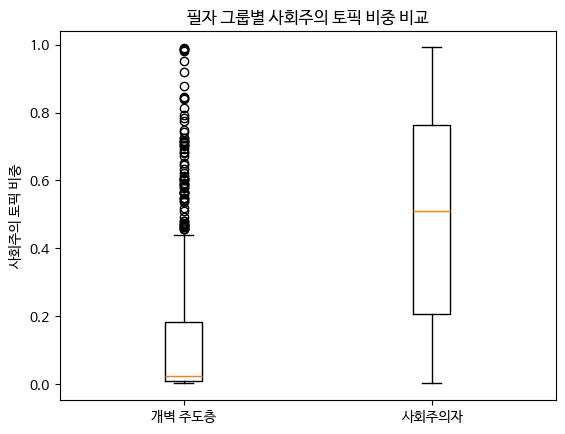

In [ ]:
import matplotlib.pyplot as plt

# 박스플롯
plt.boxplot([group_1, group_2], labels=['개벽 주도층', '사회주의자'])
plt.title('필자 그룹별 사회주의 토픽 비중 비교')
plt.ylabel('사회주의 토픽 비중')
plt.show()

In [ ]:
print(f"Group 1 Median (개벽 주도층): {group_1.median()}")
print(f"Group 2 Median (사회주의자): {group_2.median()}")

Group 1 Median (개벽 주도층): 0.024467225000000002
Group 2 Median (사회주의자): 0.51002049


## 가설검정: 통계적 확인

### 정규성 검정

In [ ]:
# 정규성 검정: 각 그룹의 T1 데이터가 정규 분포를 따르는지 검정합니다.
# Shapiro-Wilk 검정이나 Kolmogorov-Smirnov 검정을 사용할 수 있습니다.

from scipy.stats import shapiro

# 정규성 검정
stat1, p1 = shapiro(group_1)
stat2, p2 = shapiro(group_2)

print(f"Group 1 (개벽 주도층): p-value={p1}")
print(f"Group 2 (사회주의자): p-value={p2}")

Group 1 (개벽 주도층): p-value=1.2457360510751963e-33
Group 2 (사회주의자): p-value=8.021038320486169e-21


**해석**
- Shapiro-Wilk 검정의 귀무가설(H0)은 “데이터가 정규분포를 따른다.” 임. 따라서 p-value가 0.05보다 작으면 귀무가설을 기각하고, 정규분포가 아니라고 판단함.
- 이 두 값은 모두 0.05보다 매우 작다.
- 따라서 정규성이 성립하지 않음.

### Mann-Whitney U 검정

**Mann-Whitney U 검정의 귀무가설(H0)은**
- “두 그룹(집단)의 분포가 동일하며, 중위수(중앙값) 또한 차이가 없다.”라는 가정입니다.
- p-value < 0.05 (유의수준 α=0.05 가정) 이면,귀무가설을 기각하고,
- “두 그룹 간 중위수가 통계적으로 유의하게 다르다(즉, 분포가 다르다)” 라고 해석합니다.
- p-value ≥ 0.05 이면, 귀무가설을 기각하지 못하므로, “두 그룹 간 유의미한 차이가 있다고 보기 어렵다(유의 수준 0.05에서)” 라고 해석합니다.
- 따라서, Mann-Whitney U Test p-value가 0.05보다 작아야, 두 그룹(개벽 주도층과 사회주의자 그룹) 간에 통계적으로 유의미한 차이가 있다고 결론지을 수 있습니다.

In [ ]:
# 통계적 검정
"""Mann-Whitney U 검정: 정규성을 만족하지 않거나 등분산성이 충족되지 않음
   : 비모수 검정(Mann-Whitney U 검정)"""

from scipy.stats import mannwhitneyu

# Mann-Whitney U 검정
stat, p = mannwhitneyu(group_1, group_2)
print(f"Mann-Whitney U Test p-value: {p}")

Mann-Whitney U Test p-value: 3.708745224340115e-119


**[해석]**
- 수준의 극도로 작은 값이므로, 일반적인 유의 수준(α=0.05)에서는 귀무가설을 기각하게 됩니다.
- 즉, 두 그룹의 분포(중앙값)가 통계적으로 유의미하게 차이가 있다고 결론지을 수 있습니다.

# The End of Notebook